# 1. Data Preparation & Exploration

**1.1 Data Pipeline**

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, Column, Integer, Float, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

heart_data = pd.read_csv('heart_disease_uci.csv')

# Setup SQLAlchemy connection to SQLite database
engine = create_engine('sqlite:///heart_disease.db')

# Create table and upload data to database
heart_data.to_sql('heart_disease', engine, if_exists='replace', index=False)

# Query data using SQLAlchemy
query = "SELECT * FROM heart_disease"
df = pd.read_sql(query, engine)

print("Data loaded from SQLite database successfully!")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(f"Columns: {df.columns.tolist()}")

Data loaded from SQLite database successfully!
Number of rows: 920
Number of columns: 16
Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


**1.2 Cleaning Dataset**

In [3]:
# Check for missing values in each column
print(df.isnull().sum())

# Handle missing values by data type
# First, identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Fill numeric columns with mean
if len(numeric_cols) > 0:
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill categorical columns with mode (most frequent value)
if len(categorical_cols) > 0:
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values handled successfully!")

# Handle specific columns differently if needed
# Example: Fill 'age' with median instead of mean
if 'age' in df.columns and df['age'].isnull().sum() > 0:
    df['age'] = df['age'].fillna(df['age'].median())

# Example: Fill a categorical column with a specific value
if 'thal' in df.columns and df['thal'].isnull().sum() > 0:
    df['thal'] = df['thal'].fillna('normal')

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Missing values handled successfully!


**1.3 Dataset Exploration**

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    float64
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    float64
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        920 non-null    float64
 14  thal      920 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(7), int64(3), object(6)
memory usage: 115.1+ KB
None

Data types:
id            int64
age           int64
sex          object
dataset      object
cp           

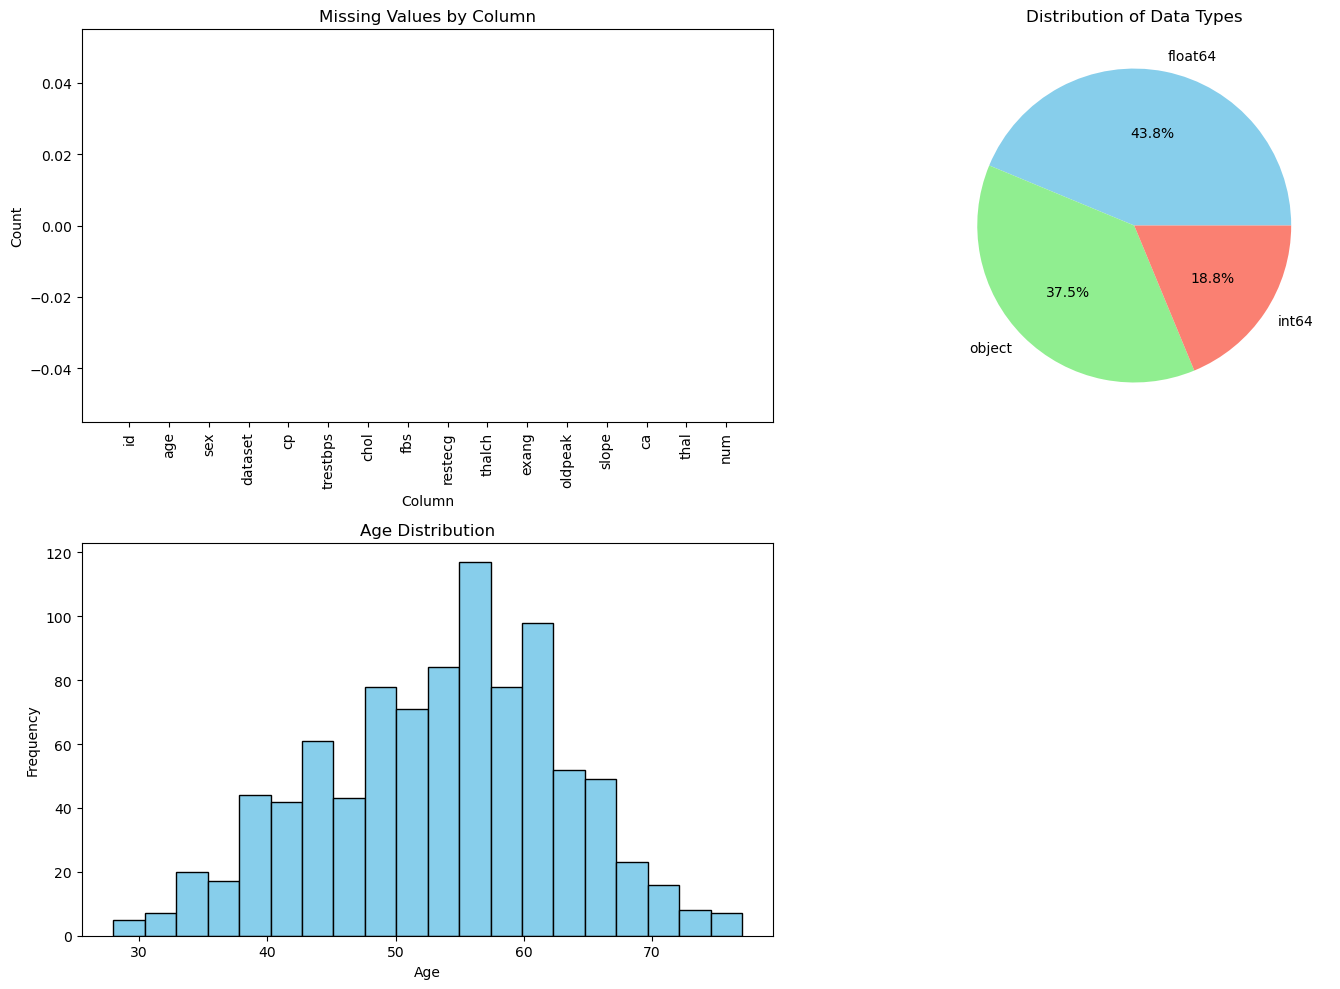


Skewness of numerical features:
id: 0.00
age: -0.20
trestbps: 0.22
chol: -0.62
fbs: 1.89
thalch: -0.22
exang: 0.47
oldpeak: 1.08
ca: 2.00
num: 0.97


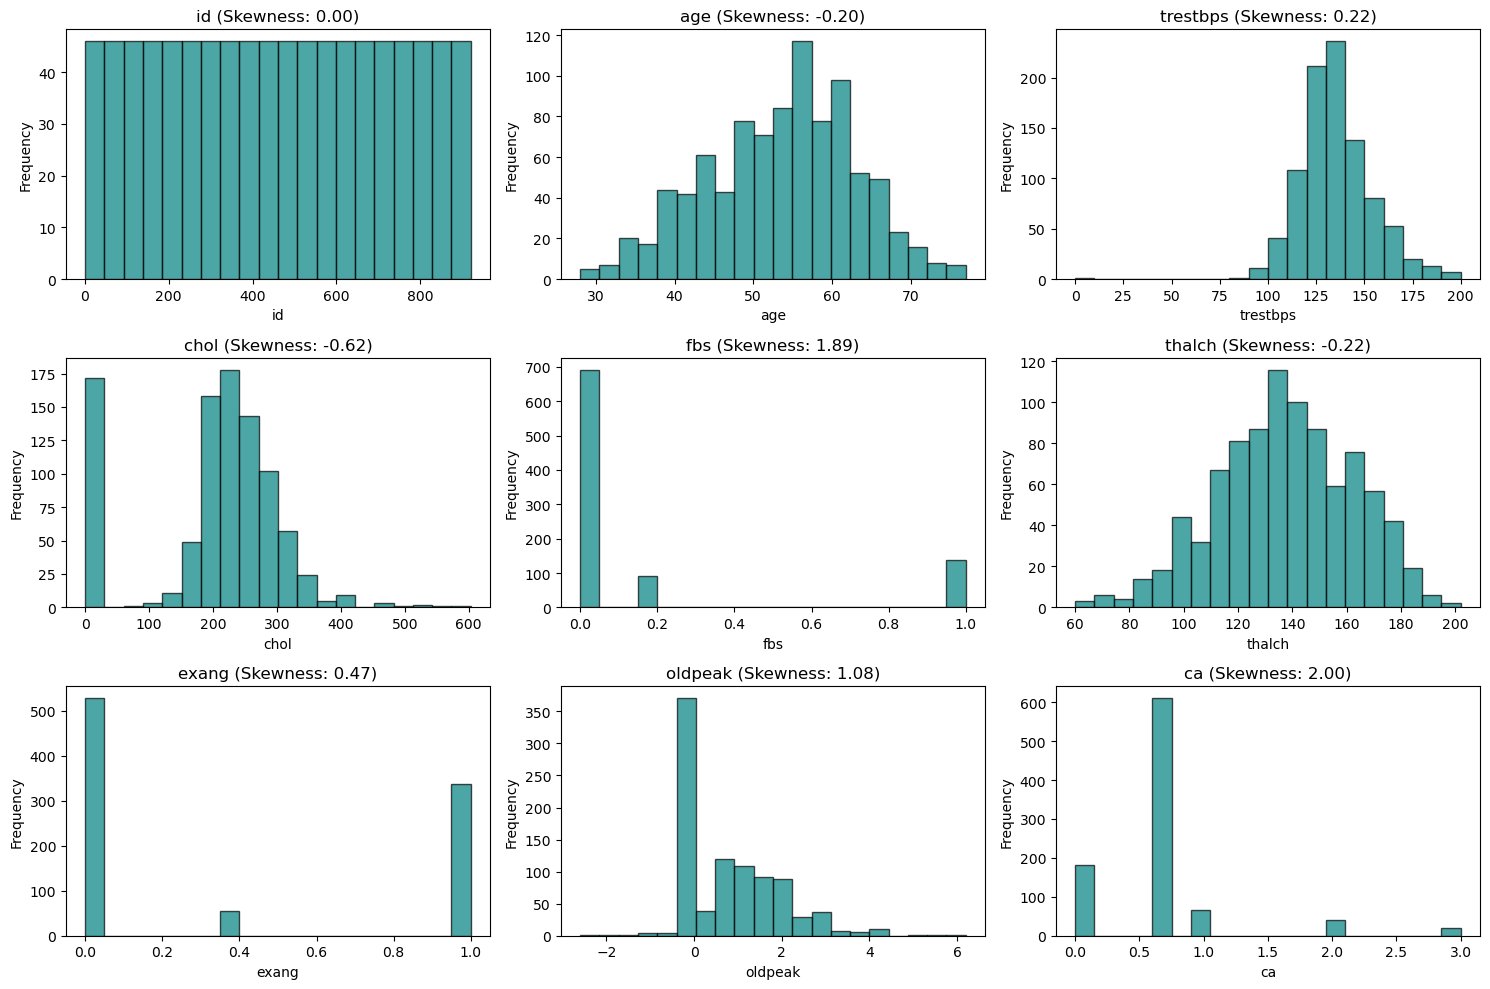

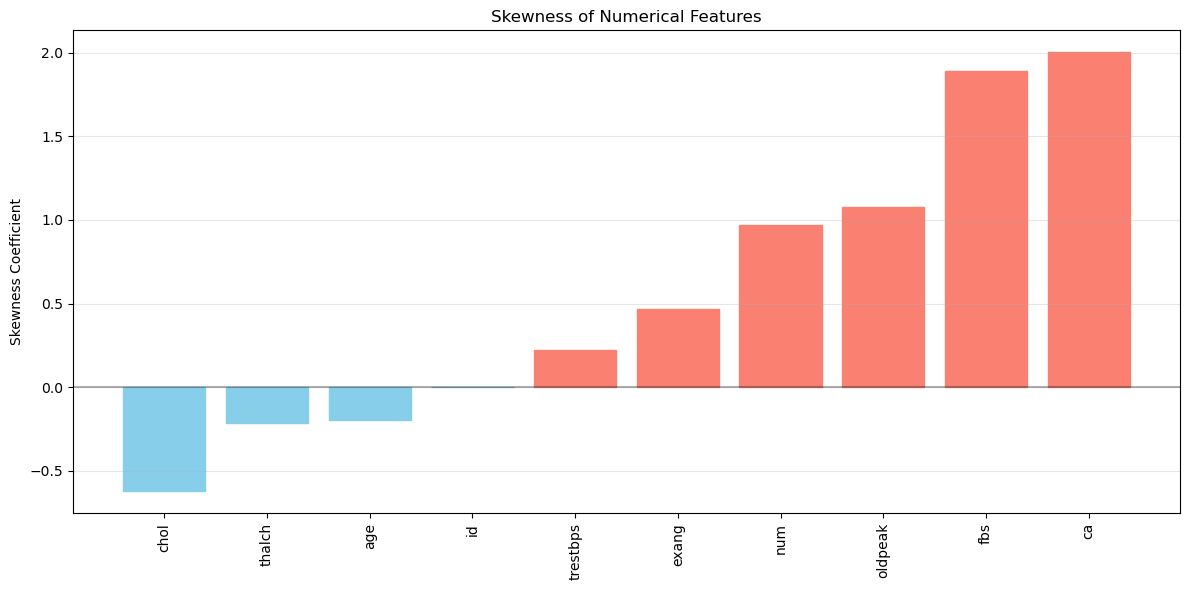

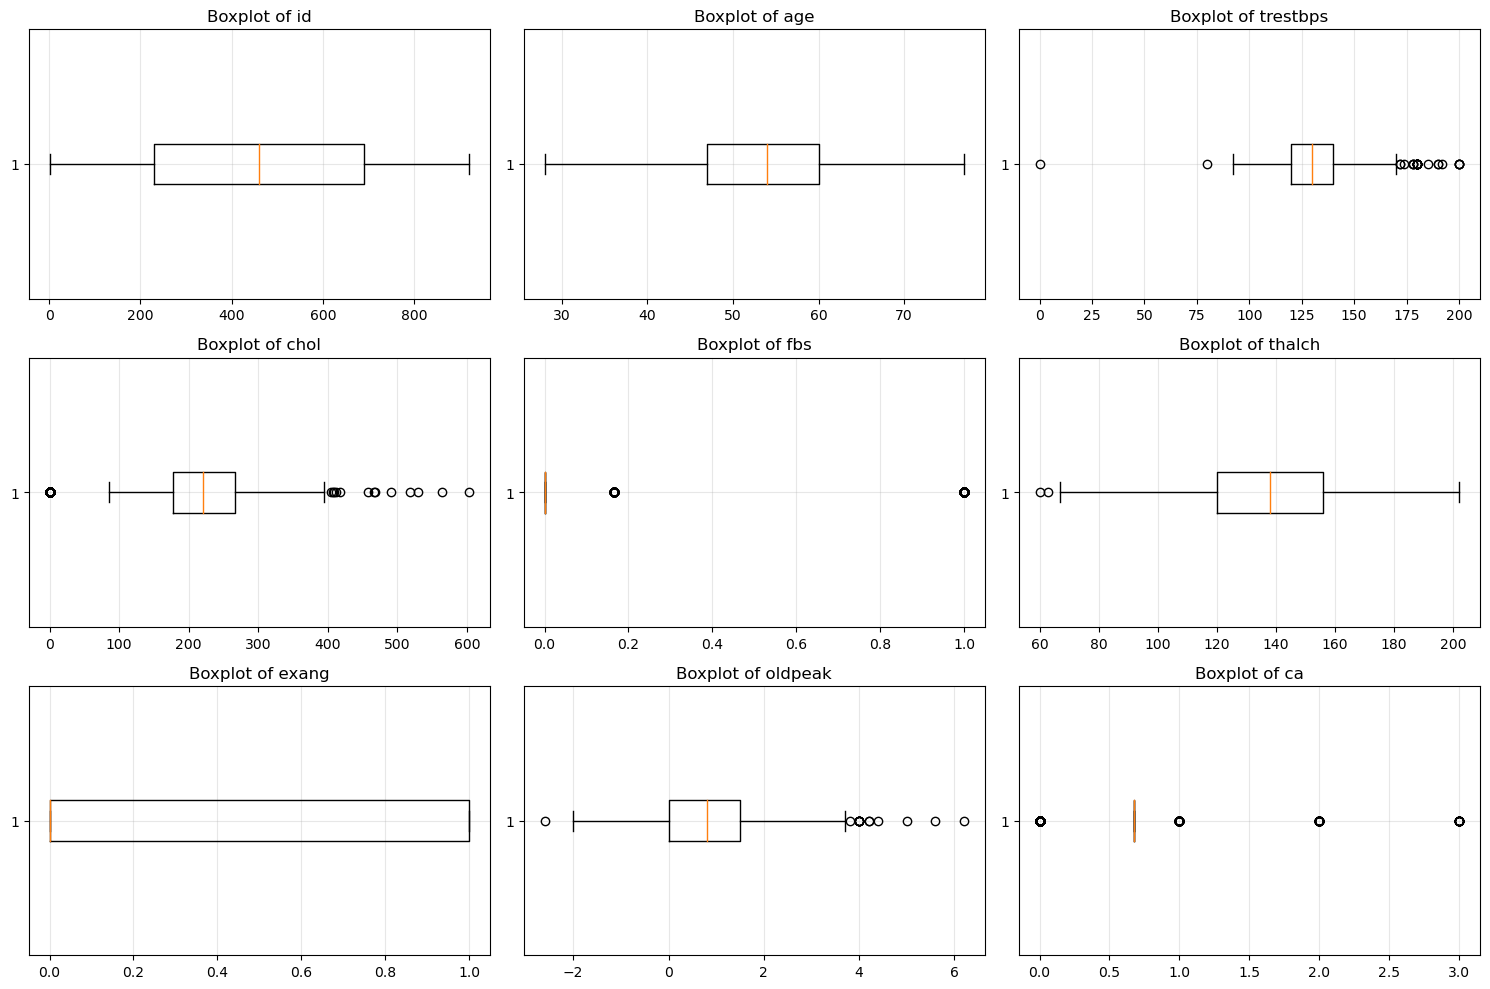

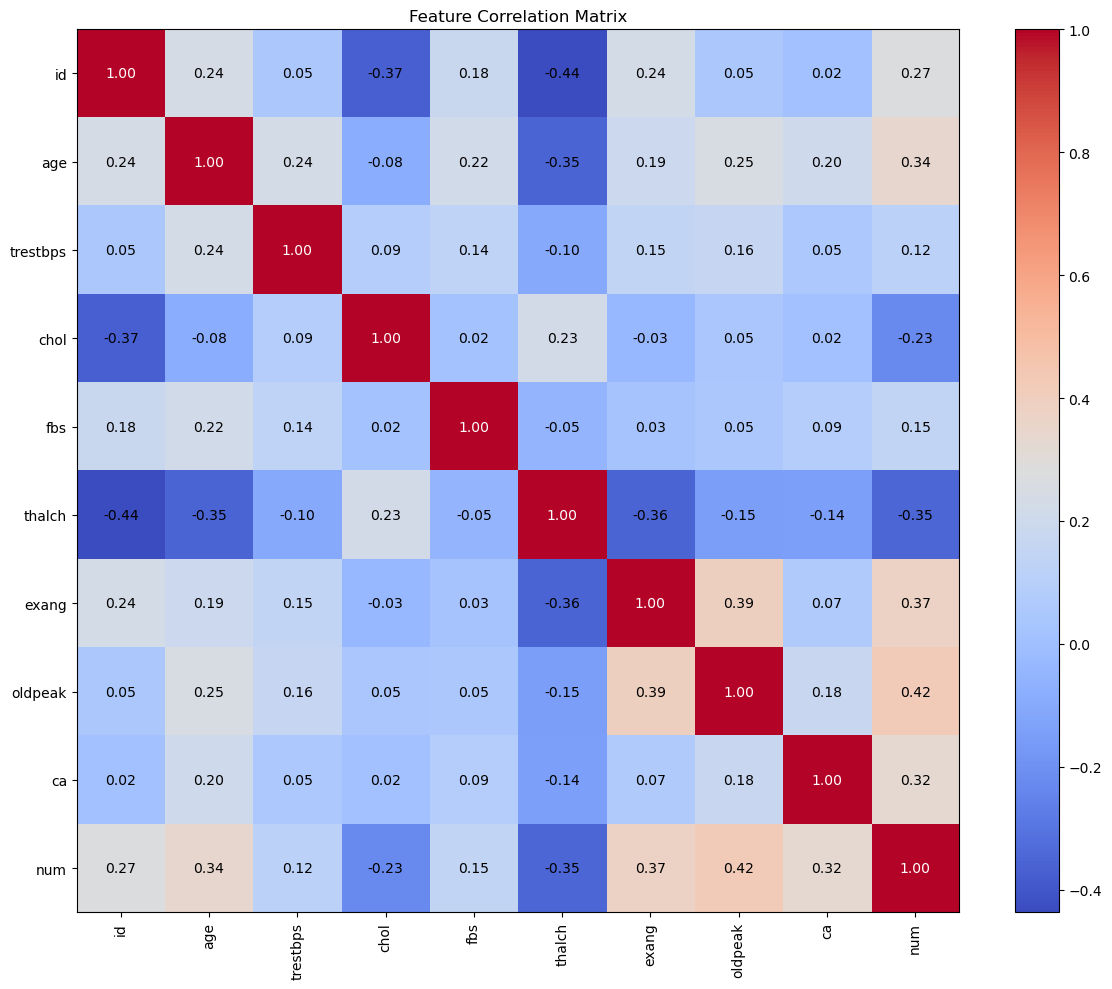

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Analyze schema and types
print("Data Information:")
print(df.info())
print("\nData types:")
print(df.dtypes)

# Generate summary statistics
print("\nSummary statistics:")
print(df.describe(include='all').T)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicates: {duplicates}")

# Visualize schema and data distributions using matplotlib
# Create a figure for dataset overview
plt.figure(figsize=(15, 10))

# Plot 1: Missing values by column
plt.subplot(2, 2, 1)
missing_data = df.isnull().sum()
plt.bar(range(len(missing_data)), missing_data, color='crimson')
plt.xticks(range(len(missing_data)), missing_data.index, rotation=90)
plt.title('Missing Values by Column')
plt.xlabel('Column')
plt.ylabel('Count')

# Plot 2: Data types distribution
plt.subplot(2, 2, 2)
dtypes_counts = df.dtypes.value_counts()
plt.pie(dtypes_counts, labels=dtypes_counts.index, autopct='%1.1f%%',
        colors=['skyblue', 'lightgreen', 'salmon', 'yellow', 'lightgray'])
plt.title('Distribution of Data Types')

# Plot 3: Distribution of a key numeric variable (e.g., age)
if 'age' in df.columns:
    plt.subplot(2, 2, 3)
    plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

# Plot 4: Count of target variable (assuming 'target' is the heart disease indicator)
if 'target' in df.columns:
    plt.subplot(2, 2, 4)
    target_counts = df['target'].value_counts()
    plt.bar(target_counts.index.astype(str), target_counts, color='lightgreen')
    plt.title('Heart Disease Status Distribution')
    plt.xlabel('Heart Disease Present (1=Yes, 0=No)')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig('dataset_overview.png')
plt.show()

# Detect skewed distributions in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nSkewness of numerical features:")

# Create figure for skewness visualization
plt.figure(figsize=(15, 10))
skewness_values = []

for i, col in enumerate(numeric_cols, 1):
    skewness = stats.skew(df[col].dropna())
    skewness_values.append((col, skewness))
    print(f"{col}: {skewness:.2f}")

    # Plot histograms to visualize skewness
    if i <= 9:  # Limit to 9 subplots to avoid overcrowding
        plt.subplot(3, 3, i)
        plt.hist(df[col], bins=20, color='teal', alpha=0.7, edgecolor='black')
        plt.title(f'{col} (Skewness: {skewness:.2f})')
        plt.xlabel(col)
        plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('numeric_distributions.png')
plt.show()

# Create a bar chart of skewness values
skewness_df = pd.DataFrame(skewness_values, columns=['Feature', 'Skewness'])
skewness_df = skewness_df.sort_values('Skewness')

plt.figure(figsize=(12, 6))
bars = plt.bar(skewness_df['Feature'], skewness_df['Skewness'], color='purple')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Color bars based on skewness direction
for i, bar in enumerate(bars):
    if skewness_df['Skewness'].iloc[i] > 0:
        bar.set_color('salmon')
    else:
        bar.set_color('skyblue')

plt.title('Skewness of Numerical Features')
plt.xticks(rotation=90)
plt.ylabel('Skewness Coefficient')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('skewness_analysis.png')
plt.show()

# Detect outliers using box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    if i <= 9:  # Limit to 9 subplots
        plt.subplot(3, 3, i)
        plt.boxplot(df[col].dropna(), vert=False)
        plt.title(f'Boxplot of {col}')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outlier_detection.png')
plt.show()

# Analyze correlations between features
if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

    # Add correlation values in the cells
    for i in range(len(correlation_matrix)):
        for j in range(len(correlation_matrix)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                     ha='center', va='center',
                     color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

**1.4 Basic EDA**

DataFrame shape: (920, 16)
First few rows:
   id  age     sex    dataset               cp  trestbps   chol  fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0  1.0   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  0.0   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  0.0   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  0.0   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  0.0   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0    0.0      2.3  downsloping  0.0   
1  lv hypertrophy   108.0    1.0      1.5         flat  3.0   
2  lv hypertrophy   129.0    1.0      2.6         flat  2.0   
3          normal   187.0    0.0      3.5  downsloping  0.0   
4  lv hypertrophy   172.0    0.0      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4    

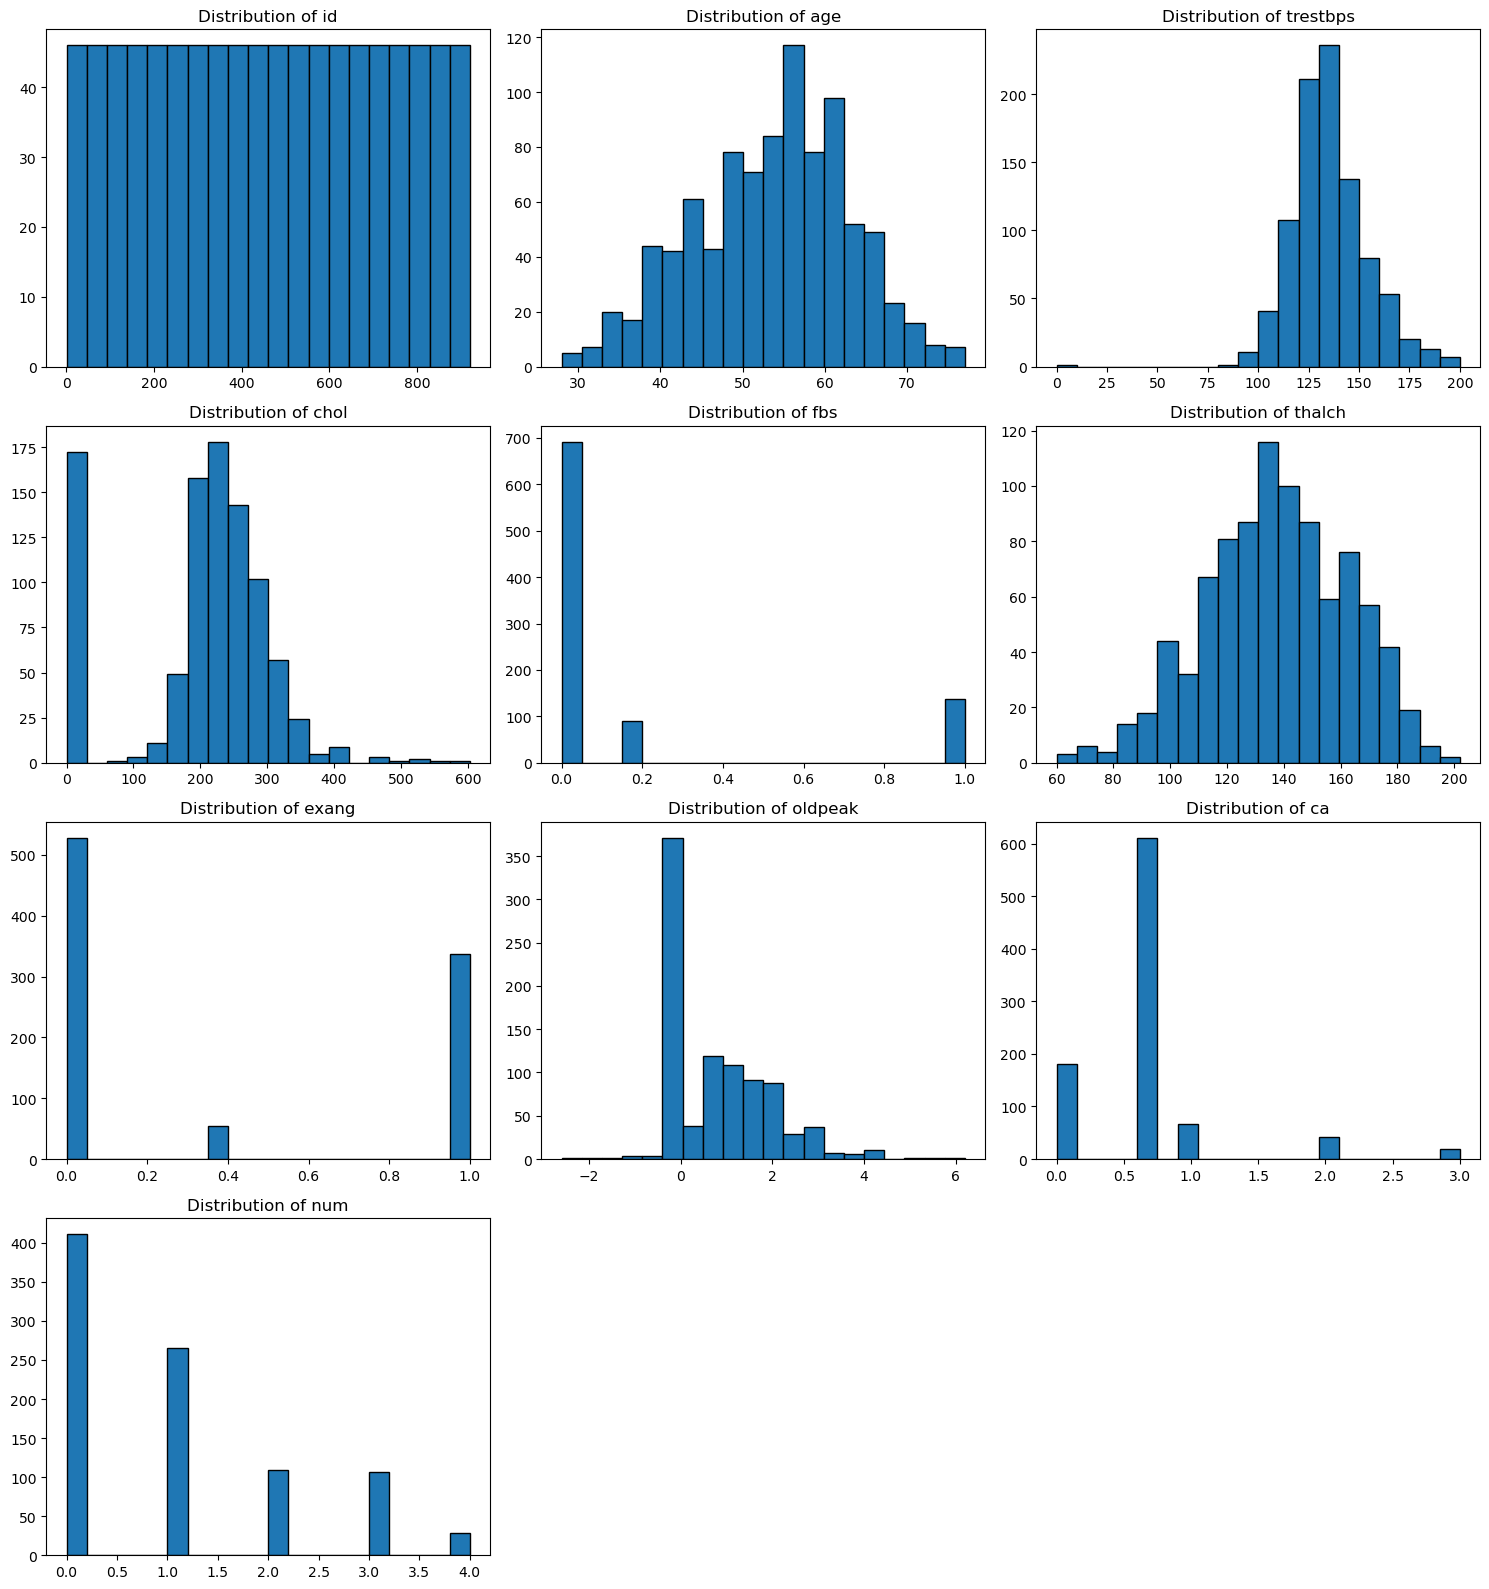


Generating bar charts for categorical columns...
Creating bar chart grid with 2 rows and 3 columns
Creating bar chart for sex at position 1
Creating bar chart for dataset at position 2
Creating bar chart for cp at position 3
Creating bar chart for restecg at position 4
Creating bar chart for slope at position 5
Creating bar chart for thal at position 6
Displaying bar charts...


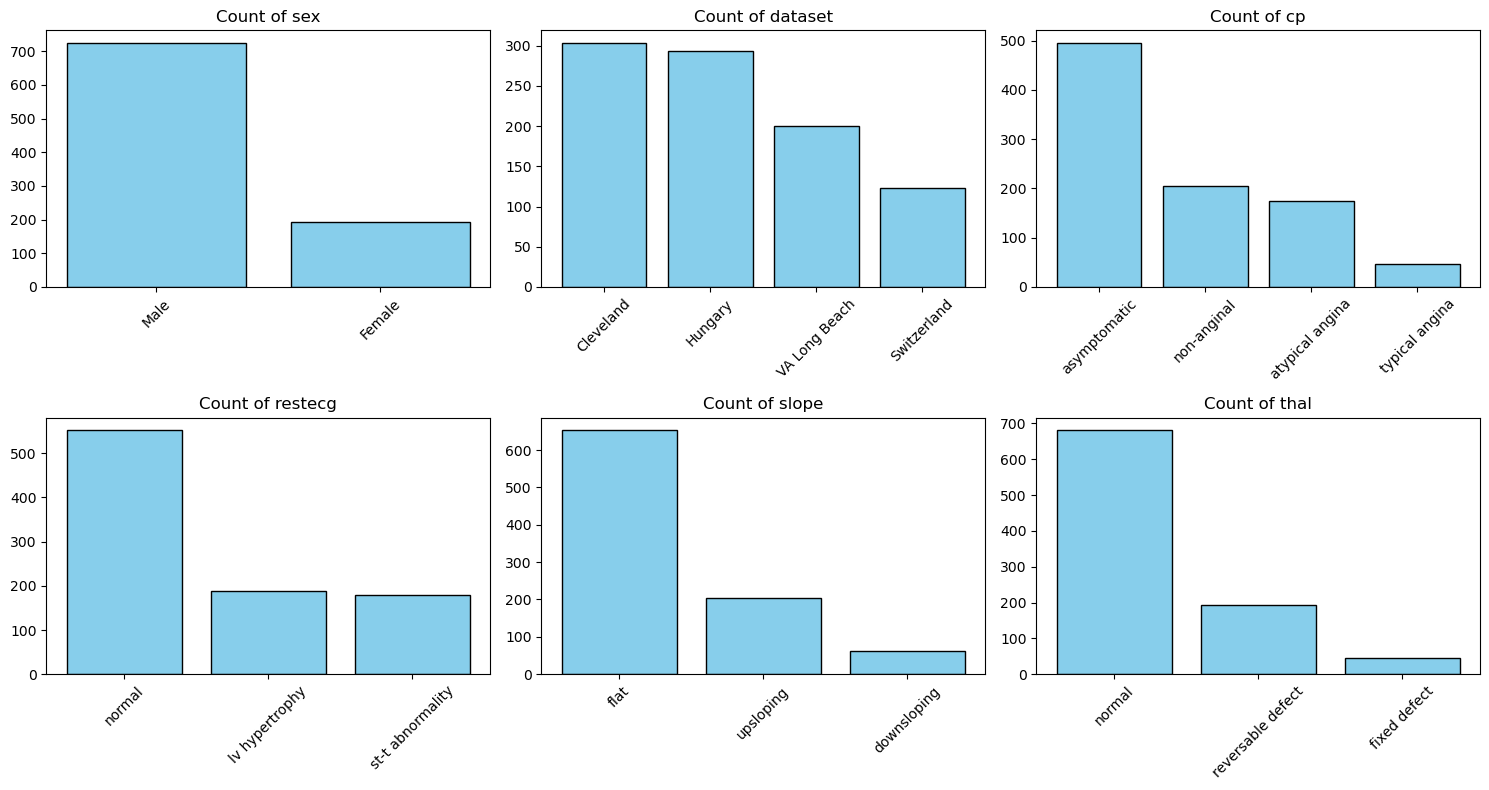


Generating boxplots for numeric columns...
Creating boxplot grid with 4 rows and 3 columns
Creating boxplot for id at position 1
Creating boxplot for age at position 2
Creating boxplot for trestbps at position 3
Creating boxplot for chol at position 4
Creating boxplot for fbs at position 5
Creating boxplot for thalch at position 6
Creating boxplot for exang at position 7
Creating boxplot for oldpeak at position 8
Creating boxplot for ca at position 9
Creating boxplot for num at position 10
Displaying boxplots...


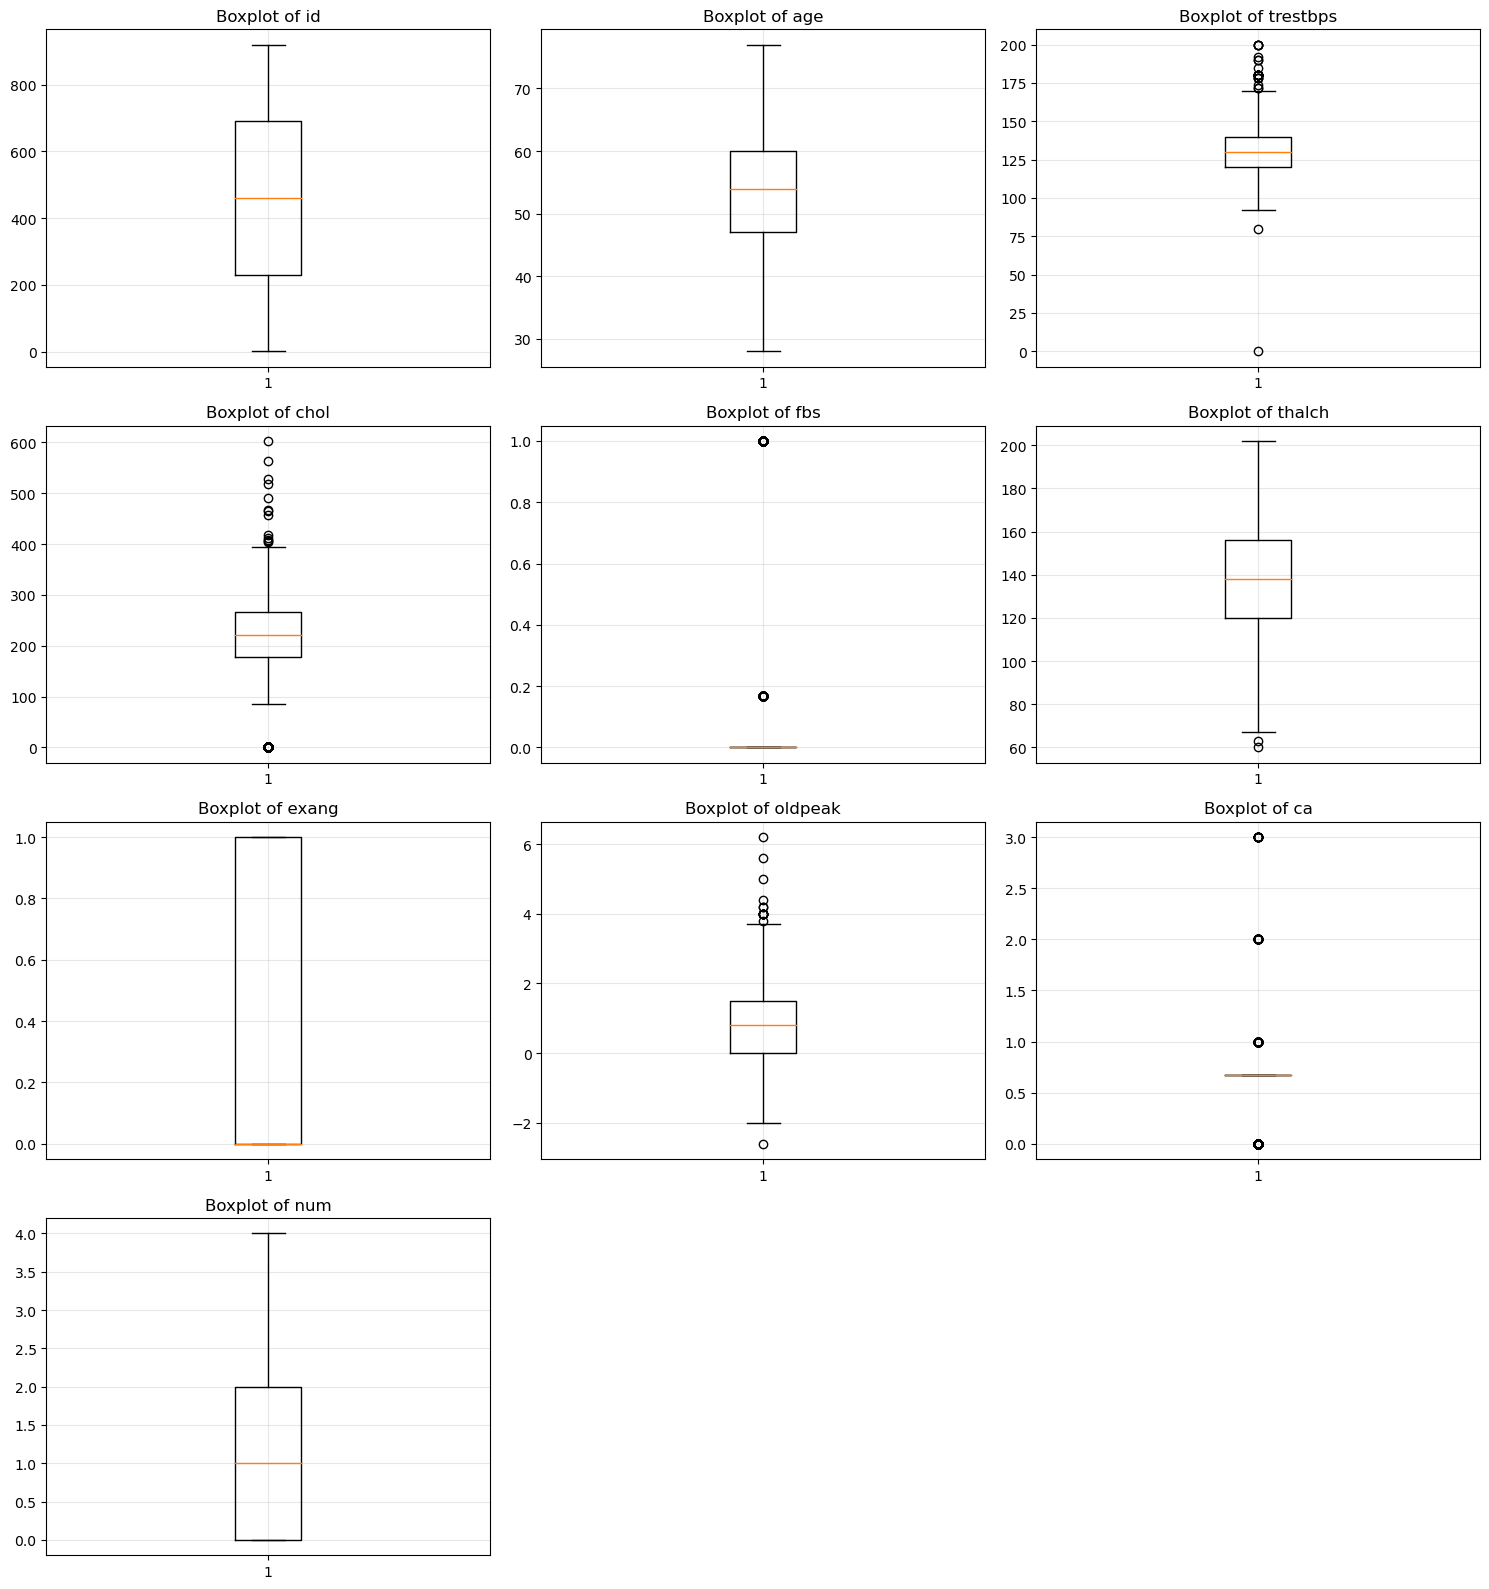

In [5]:
print(f"DataFrame shape: {df.shape}")
print(f"First few rows:\n{df.head()}")

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Create a function to plot histograms for numeric features
def plot_histograms(df, numeric_columns):
    if len(numeric_columns) == 0:
        print("No numeric columns to plot histograms for.")
        return

    # Calculate number of rows needed based on number of columns
    n_cols = min(3, len(numeric_columns))  # Max 3 columns in the grid
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Ceiling division

    print(f"Creating histogram grid with {n_rows} rows and {n_cols} columns")
    plt.figure(figsize=(15, n_rows * 4))  # Adjust height based on number of rows

    for i, column in enumerate(numeric_columns, 1):
        print(f"Creating histogram for {column} at position {i}")
        plt.subplot(n_rows, n_cols, i)
        plt.hist(df[column], bins=20, edgecolor='black')
        plt.title(f'Distribution of {column}')

    plt.tight_layout()
    print("Displaying histograms...")
    plt.savefig('histograms.png')  # Save the figure to a file
    plt.show()

# Create a function to plot bar plots for categorical features
def plot_barplots(df, categorical_columns):
    if len(categorical_columns) == 0:
        print("No categorical columns to plot bar charts for.")
        return

    # Calculate number of rows needed
    n_cols = min(3, len(categorical_columns))  # Max 3 columns in the grid
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Ceiling division

    print(f"Creating bar chart grid with {n_rows} rows and {n_cols} columns")
    plt.figure(figsize=(15, n_rows * 4))

    for i, column in enumerate(categorical_columns, 1):
        print(f"Creating bar chart for {column} at position {i}")
        plt.subplot(n_rows, n_cols, i)
        value_counts = df[column].value_counts()
        plt.bar(value_counts.index.astype(str), value_counts, color='skyblue', edgecolor='black')
        plt.title(f'Count of {column}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    print("Displaying bar charts...")
    plt.savefig('barcharts.png')  # Save the figure to a file
    plt.show()

# Create box plots to identify outliers
def plot_boxplots(df, numeric_columns):
    if len(numeric_columns) == 0:
        print("No numeric columns to plot boxplots for.")
        return

    # Calculate number of rows needed
    n_cols = min(3, len(numeric_columns))  # Max 3 columns in the grid
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Ceiling division

    print(f"Creating boxplot grid with {n_rows} rows and {n_cols} columns")
    plt.figure(figsize=(15, n_rows * 4))

    for i, column in enumerate(numeric_columns, 1):
        print(f"Creating boxplot for {column} at position {i}")
        plt.subplot(n_rows, n_cols, i)
        plt.boxplot(df[column].dropna())
        plt.title(f'Boxplot of {column}')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    print("Displaying boxplots...")
    plt.savefig('boxplots.png')  # Save the figure to a file
    plt.show()

# Make sure we call each function
print("\nGenerating histograms for numeric columns...")
plot_histograms(df, numeric_cols)

print("\nGenerating bar charts for categorical columns...")
plot_barplots(df, categorical_cols)

print("\nGenerating boxplots for numeric columns...")
plot_boxplots(df, numeric_cols)

# Group-based statistics
if 'target' in df.columns:
    print("\nAverage values by target (heart disease presence):")
    print(df.groupby('target').mean())

# 2. QA & Visualization


# Q&A

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [7]:
# Identify the target column - it's typically named 'target' in this dataset
if 'target' in df.columns:
    target_column = 'target'
else:
    # Look for other potential target columns
    possible_names = ['heart_disease', 'disease', 'diagnosis', 'label', 'class', 'num']
    for col in possible_names:
        if col in df.columns:
            target_column = col
            break
    else:
        # If no known name is found, look for a binary column at the end
        binary_cols = [col for col in df.columns if df[col].nunique() <= 2]
        if binary_cols:
            target_column = binary_cols[-1]
        else:
            raise ValueError("Could not identify target column")

print(f"\nUsing '{target_column}' as target column")
print(f"Target value distribution:\n{df[target_column].value_counts()}")


Using 'num' as target column
Target value distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


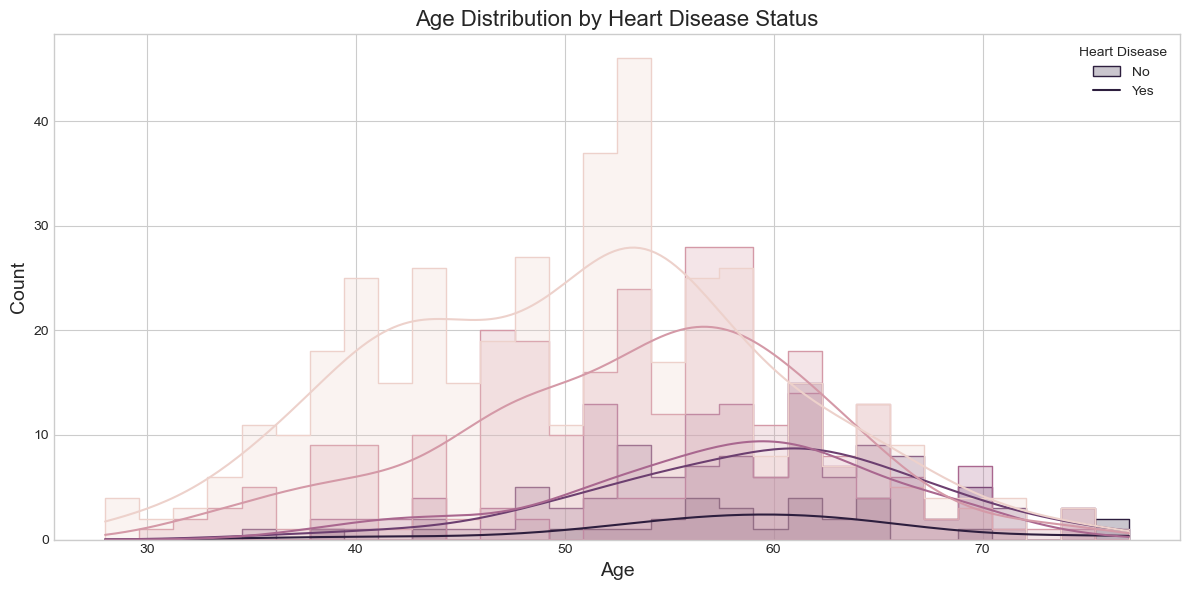

In [8]:
# ----- QUESTION 1: How does age relate to heart disease occurrence? -----
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue=target_column, bins=30, kde=True, element="step")
plt.title('Age Distribution by Heart Disease Status', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.tight_layout()
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

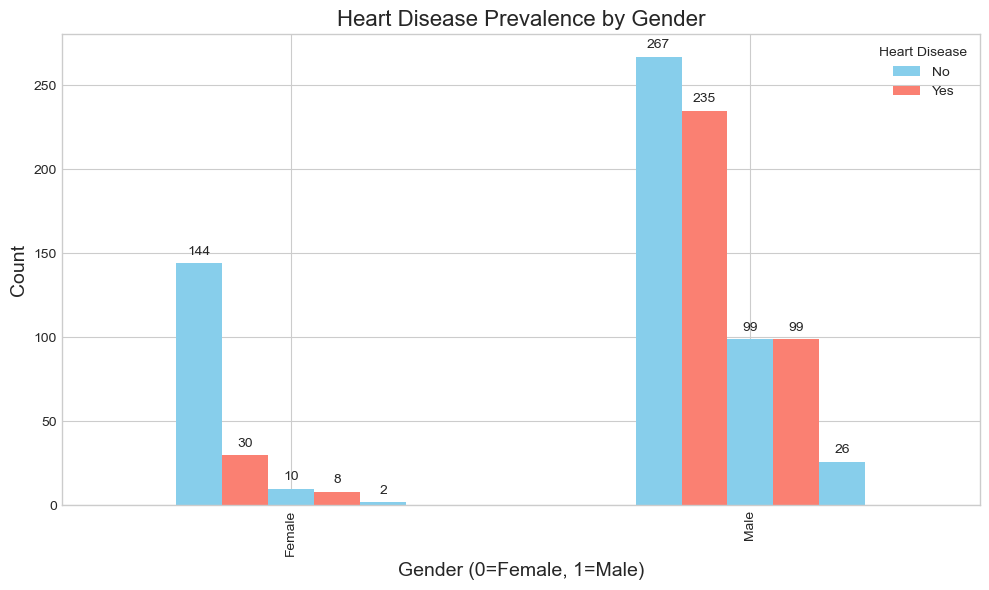

In [9]:
# ----- QUESTION 2: What is the relationship between gender and heart disease? -----
# First, identify the gender column (may be named 'sex' in this dataset)
gender_col = 'sex' if 'sex' in df.columns else None
if gender_col:
    # Count plot of heart disease by gender
    plt.figure(figsize=(10, 6))
    gender_heart = pd.crosstab(df[gender_col], df[target_column])
    gender_heart_pct = gender_heart.div(gender_heart.sum(1), axis=0) * 100

    # Plot
    ax = gender_heart.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.title('Heart Disease Prevalence by Gender', fontsize=16)
    plt.xlabel('Gender (0=Female, 1=Male)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks([0, 1], ['Female', 'Male'])
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])

    # Add percentage annotations
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.0f}', (x + width/2, y + height + 5), ha='center')

    plt.tight_layout()
    plt.savefig('gender_heart_disease.png', dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 1200x600 with 0 Axes>

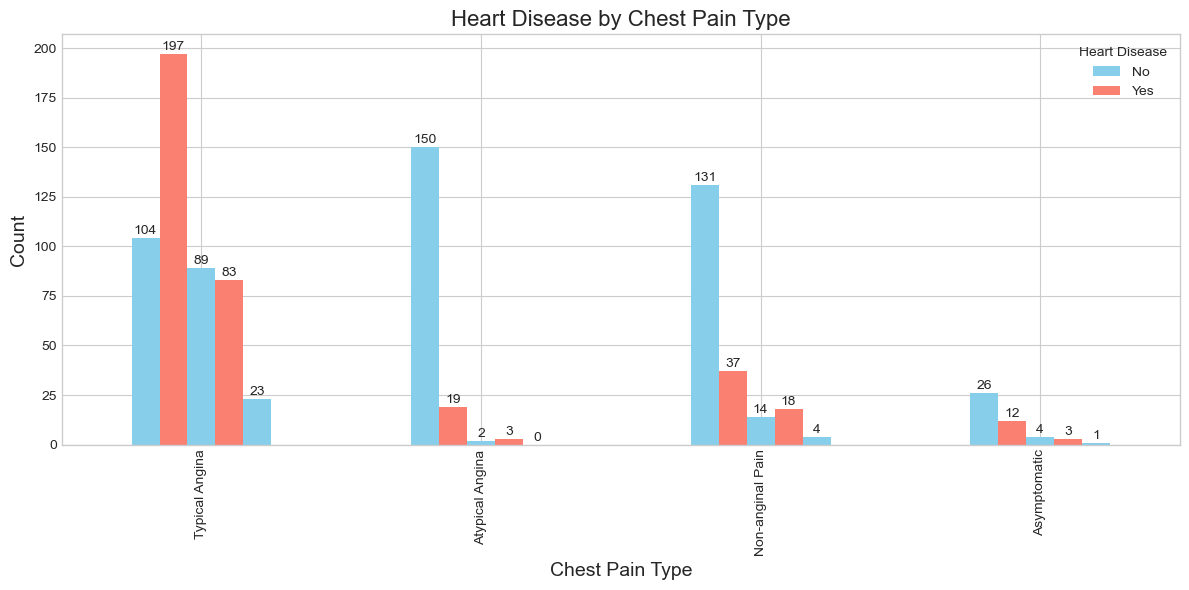

<Figure size 1200x600 with 0 Axes>

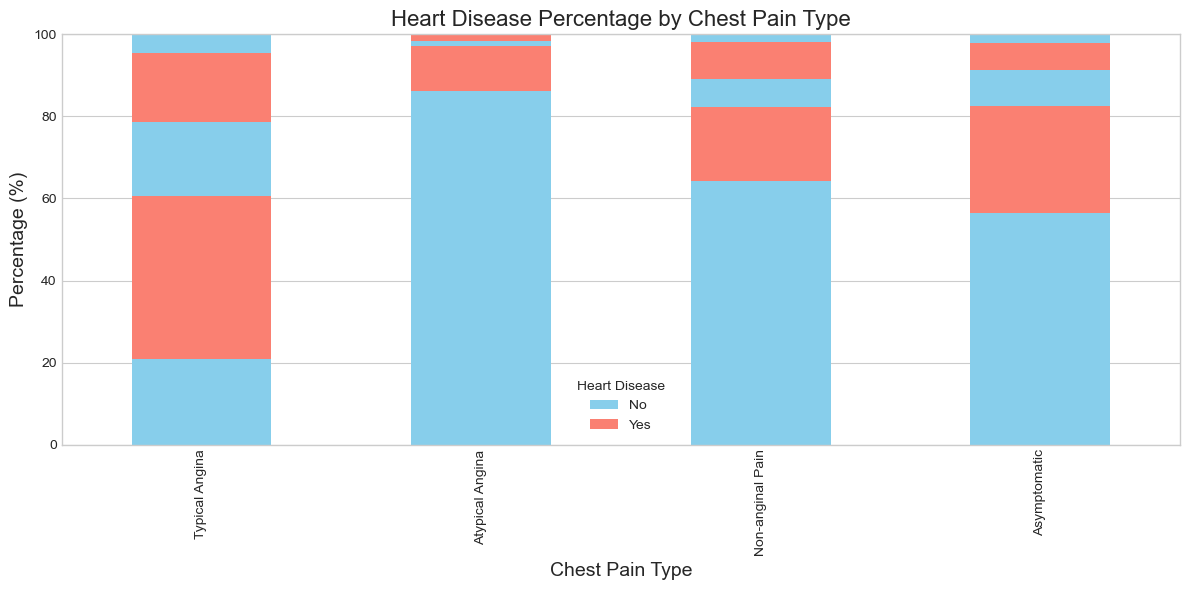

In [10]:
# ----- QUESTION 3: How do different chest pain types correlate with heart disease? -----
# Check if chest pain type column exists (cp in the UCI Heart Disease dataset)
if 'cp' in df.columns:
    plt.figure(figsize=(12, 6))
    cp_heart = pd.crosstab(df['cp'], df[target_column])

    # Plot
    ax = cp_heart.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
    plt.title('Heart Disease by Chest Pain Type', fontsize=16)
    plt.xlabel('Chest Pain Type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks([0, 1, 2, 3], ['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])

    # Add count annotations
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.0f}', (x + width/2, y + height + 2), ha='center')

    plt.tight_layout()
    plt.savefig('chest_pain_heart_disease.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Percentage plot
    plt.figure(figsize=(12, 6))
    cp_heart_pct = cp_heart.div(cp_heart.sum(1), axis=0) * 100
    cp_heart_pct.plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'salmon'])
    plt.title('Heart Disease Percentage by Chest Pain Type', fontsize=16)
    plt.xlabel('Chest Pain Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks([0, 1, 2, 3], ['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig('chest_pain_heart_disease_pct.png', dpi=300, bbox_inches='tight')
    plt.show()


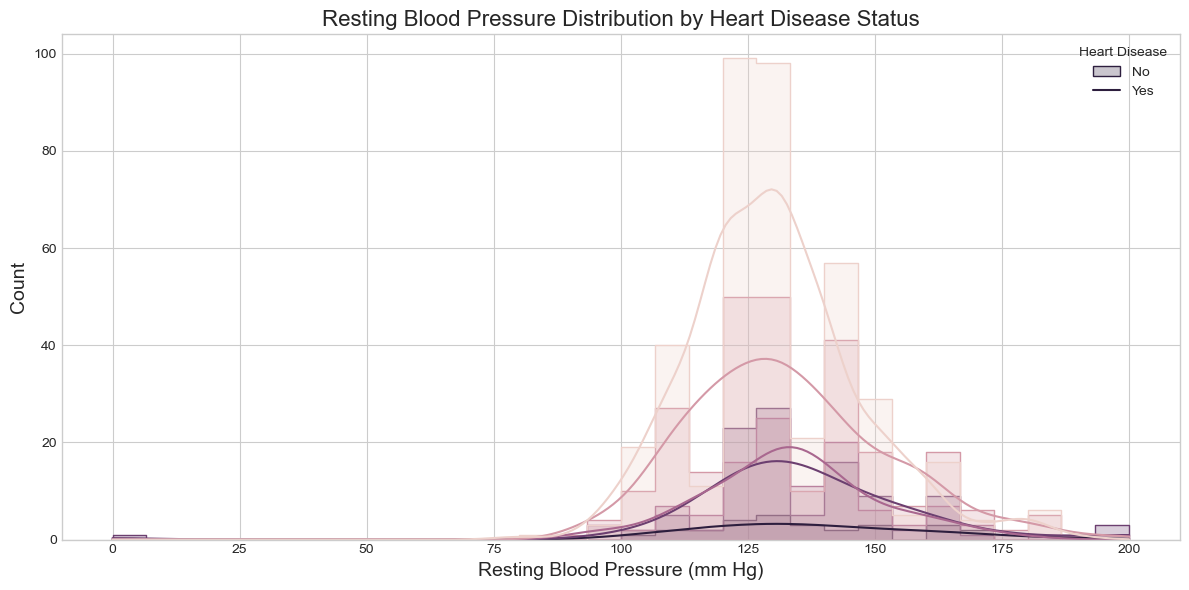

In [11]:
# ----- QUESTION 4: How do resting blood pressure levels vary between patients with and without heart disease? -----
if 'trestbps' in df.columns:  # trestbps is resting blood pressure in UCI dataset
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='trestbps', hue=target_column, bins=30, kde=True, element="step")
    plt.title('Resting Blood Pressure Distribution by Heart Disease Status', fontsize=16)
    plt.xlabel('Resting Blood Pressure (mm Hg)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.savefig('resting_bp_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


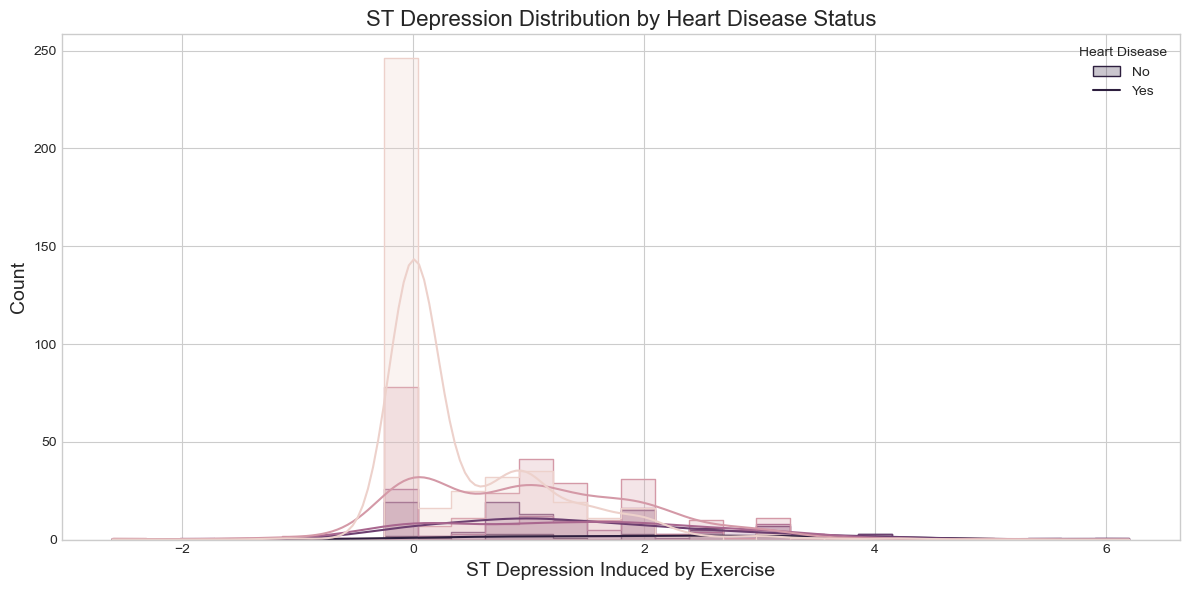

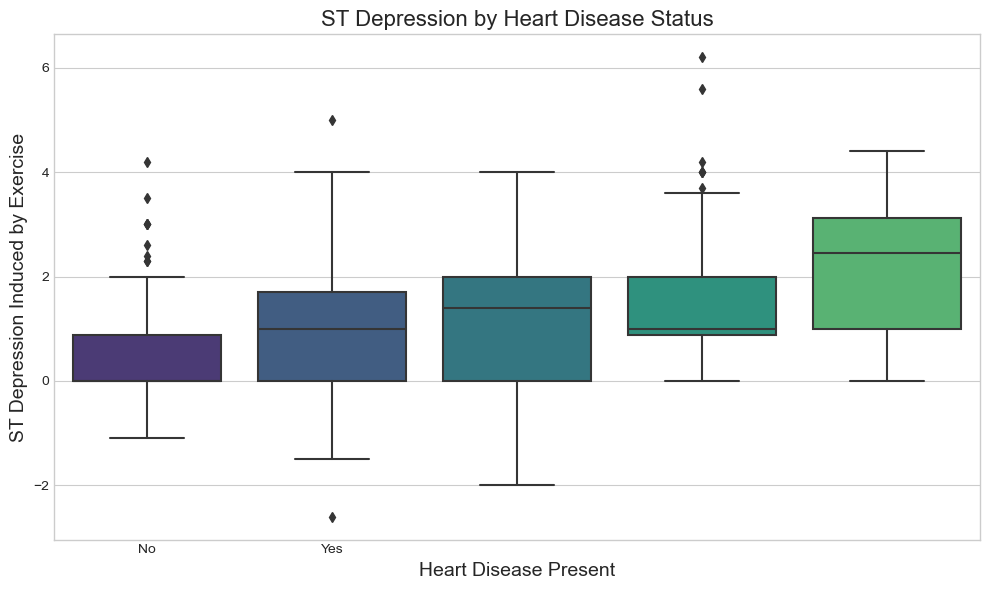

In [12]:
# ----- QUESTION 5: How does ST depression induced by exercise relate to heart disease? -----
if 'oldpeak' in df.columns:  # oldpeak is ST depression in UCI dataset
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='oldpeak', hue=target_column, bins=30, kde=True, element="step")
    plt.title('ST Depression Distribution by Heart Disease Status', fontsize=16)
    plt.xlabel('ST Depression Induced by Exercise', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.savefig('st_depression_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target_column, y='oldpeak', data=df)
    plt.title('ST Depression by Heart Disease Status', fontsize=16)
    plt.xlabel('Heart Disease Present', fontsize=14)
    plt.ylabel('ST Depression Induced by Exercise', fontsize=14)
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.tight_layout()
    plt.savefig('st_depression_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

**3. Modeling**

**3.1 Baseline Model**


Using 'num' as target column
Target value distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64
Target value percentages:
num
0    44.7
1    28.8
2    11.8
3    11.6
4     3.0
Name: proportion, dtype: float64%

Dummy Classifier (most_frequent):
Accuracy: 0.4174
Precision: 0.1742
Recall: 0.4174
F1 Score: 0.2458

Dummy Classifier (stratified):
Accuracy: 0.3609
Precision: 0.3286
Recall: 0.3609
F1 Score: 0.3409

Dummy Classifier (uniform):
Accuracy: 0.1739
Precision: 0.2475
Recall: 0.1739
F1 Score: 0.1940

Dummy Classifier (constant):
Accuracy: 0.4174
Precision: 0.1742
Recall: 0.4174
F1 Score: 0.2458
y_test shape: (230,), y_prob shape: (230, 5)
y_binarized shape: (230, 5)
y_prob shape: (230, 5)


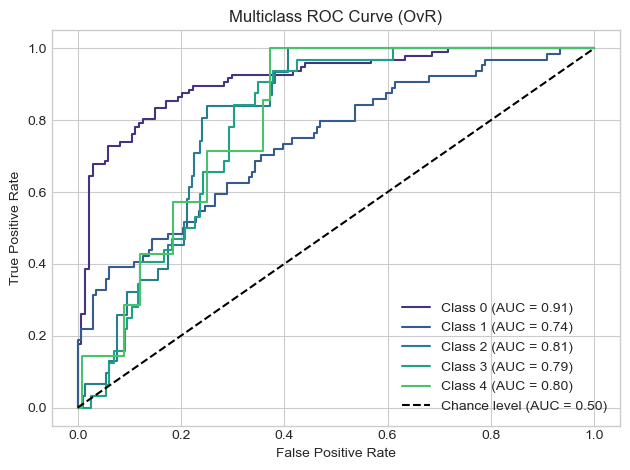


Logistic Regression Results:
Accuracy: 0.5652
Precision: 0.4760
Recall: 0.5652
F1 Score: 0.4985
ROC AUC (OvR): 0.8302
Average Precision Score: 0.6234

5-Fold CV Accuracy: 0.6188 ± 0.0262

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        96
           1       0.47      0.58      0.52        64
           2       0.25      0.03      0.06        31
           3       0.18      0.09      0.12        32
           4       0.00      0.00      0.00         7

    accuracy                           0.57       230
   macro avg       0.32      0.33      0.30       230
weighted avg       0.48      0.57      0.50       230



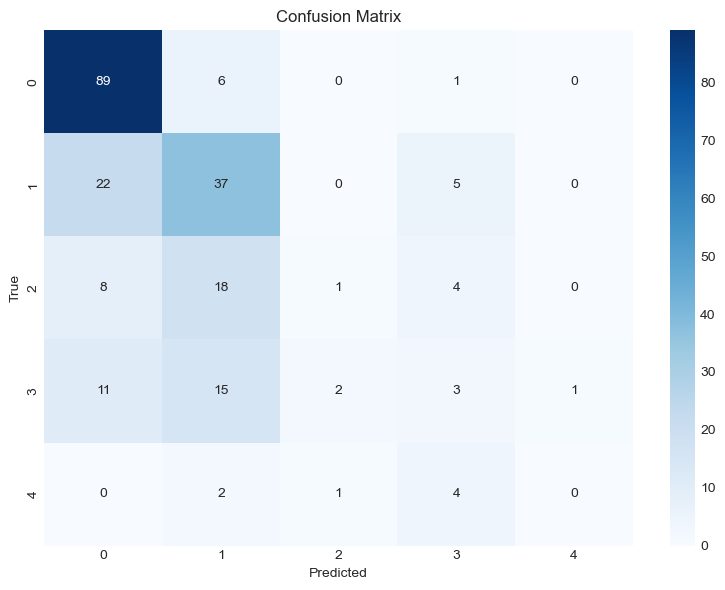

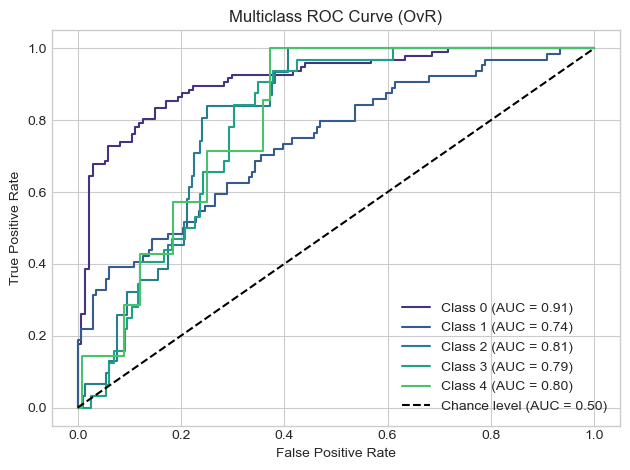

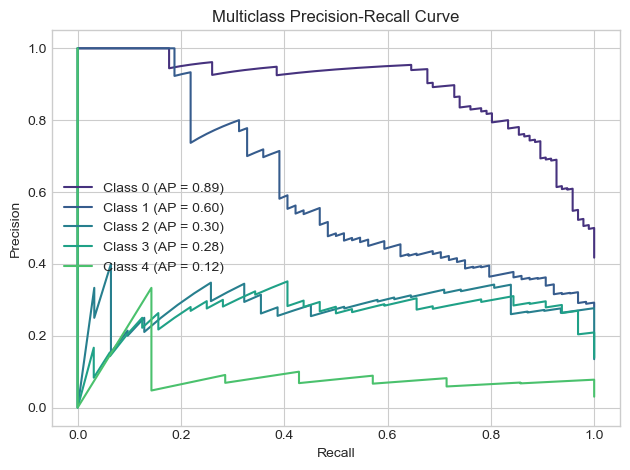


Top 10 Important Features:
                     Feature  Importance
10           dataset_Hungary    1.307903
12     dataset_VA Long Beach    1.213885
13        cp_atypical angina    1.066888
11       dataset_Switzerland    0.839987
9                   sex_Male    0.760547
0                         id    0.596022
14            cp_non-anginal    0.519879
15         cp_typical angina    0.438231
16            restecg_normal    0.433514
17  restecg_st-t abnormality    0.433113


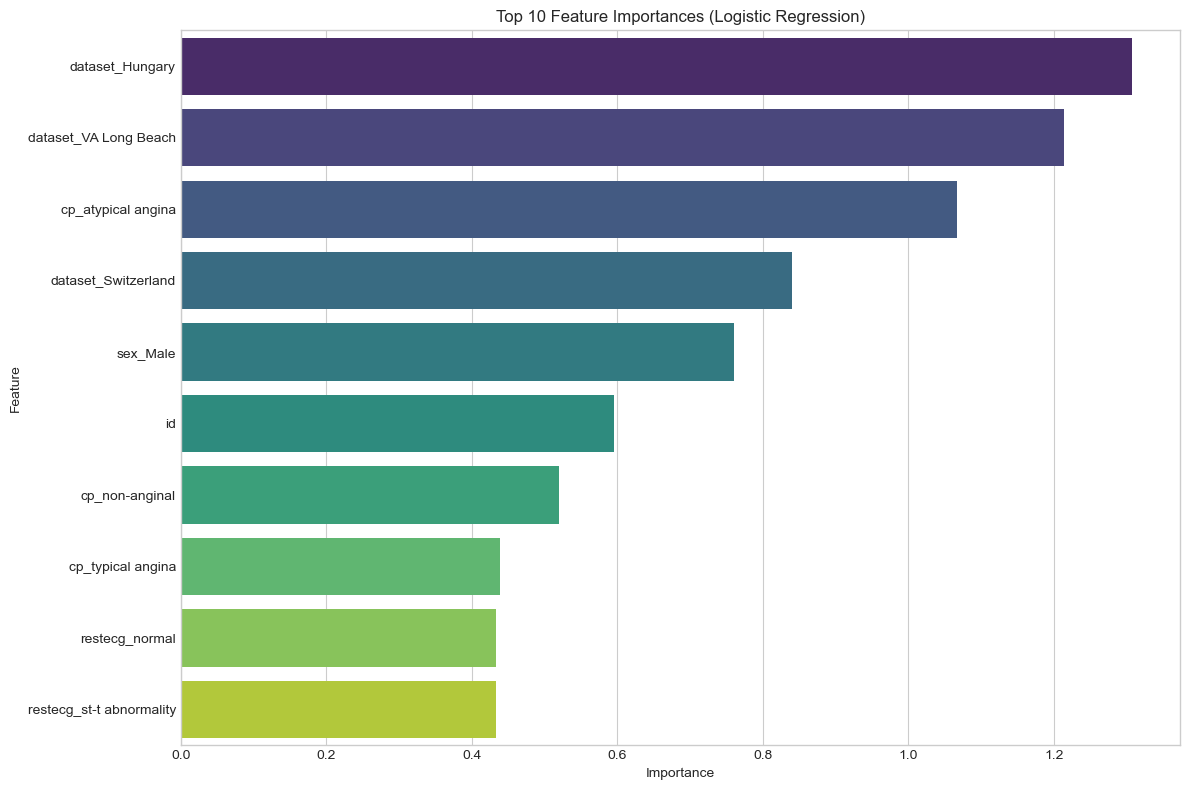


Model Comparison:
                     accuracy  \
most_frequent        0.417391   
stratified            0.36087   
uniform              0.173913   
constant             0.417391   
Logistic Regression  0.565217   

                                                             precision  \
most_frequent                                                 0.174216   
stratified                                                    0.328586   
uniform                                                       0.247536   
constant                                                      0.174216   
Logistic Regression  [0.030434782608695653, 0.03056768558951965, 0....   

                                                                recall  \
most_frequent                                                 0.417391   
stratified                                                     0.36087   
uniform                                                       0.173913   
constant                                 

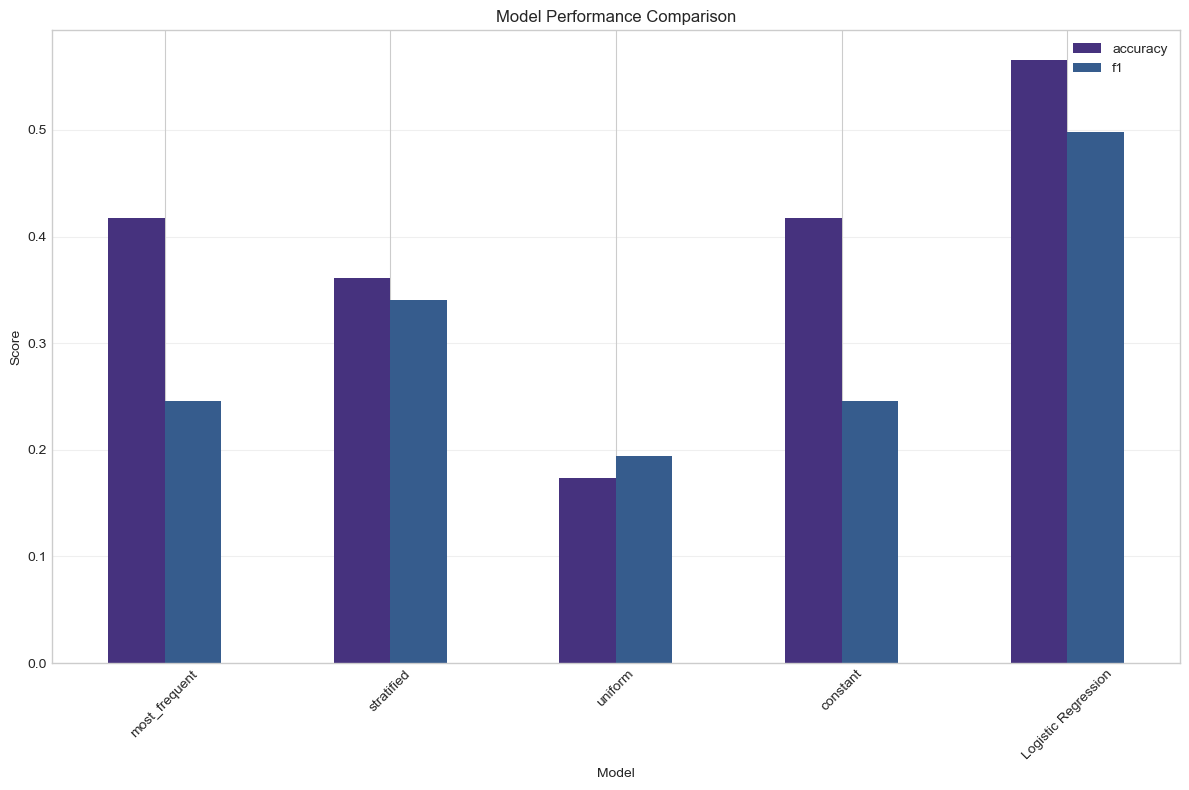

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc


# Load dataset (replace this with your actual dataset loading)
# df = pd.read_csv("your_dataset.csv")

# Identify target
if 'target' in df.columns:
    target_column = 'target'
else:
    possible_names = ['heart_disease', 'disease', 'diagnosis', 'label', 'class', 'num']
    for col in possible_names:
        if col in df.columns:
            target_column = col
            break
    else:
        binary_cols = [col for col in df.columns if df[col].nunique() <= 2]
        if binary_cols:
            target_column = binary_cols[-1]
        else:
            raise ValueError("Could not identify target column")

print(f"\nUsing '{target_column}' as target column")
print(f"Target value distribution:\n{df[target_column].value_counts()}")
print(f"Target value percentages:\n{df[target_column].value_counts(normalize=True).round(3) * 100}%")

X = df.drop(target_column, axis=1)
y = df[target_column]

# Multiclass setup
class_names = sorted(y.unique())
n_classes = len(class_names)
y_binarized = label_binarize(y, classes=class_names) if n_classes > 2 else y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_features:
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    ohe = preprocessor.named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_feature_names)
else:
    scaler = StandardScaler()
    X_train_processed = scaler.fit_transform(X_train)
    X_test_processed = scaler.transform(X_test)
    all_feature_names = numeric_features

# Dummy Classifiers
dummy_strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
dummy_results = {}

for strategy in dummy_strategies:
    if strategy == 'constant':
        dummy = DummyClassifier(strategy=strategy, random_state=42, constant=class_names[0])
    else:
        dummy = DummyClassifier(strategy=strategy, random_state=42)

    dummy.fit(X_train_processed, y_train)
    y_pred = dummy.predict(X_test_processed)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    dummy_results[strategy] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\nDummy Classifier ({strategy}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Logistic Regression model
y_pred = logreg.predict(X_test_processed)
y_prob = logreg.predict_proba(X_test_processed)

# Ensure y_test and y_prob have the same number of samples
print(f"y_test shape: {y_test.shape}, y_prob shape: {y_prob.shape}")

# If multiclass, binarize the y_test labels for ROC curve
y_binarized = label_binarize(y_test, classes=class_names) if n_classes > 2 else y_test

# Check the shape of y_binarized
print(f"y_binarized shape: {y_binarized.shape}")
print(f"y_prob shape: {y_prob.shape}")

# Now that the shapes are consistent, let's proceed to plot the ROC curve for each class

# ROC Curve (Multiclass)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_prob[:, i])  # One-vs-Rest for each class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Plot details
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.50)')
plt.title("Multiclass ROC Curve (OvR)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Ensure y_test and y_prob have the same number of samples
#####print(f"y_test shape: {y_test.shape}, y_prob shape: {y_prob.shape}")

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# For multiclass, we can use the original y_test and y_prob directly
average_precision = average_precision_score(y_test, y_prob, average='weighted')

# Print results
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC (OvR): {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


cv_scores = cross_val_score(logreg, X_train_processed, y_train, cv=5)
print(f"\n5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (Multiclass)
# Loop over each class to plot the ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_prob[:, i])  # One-vs-Rest for each class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Plot details
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.50)')
plt.title("Multiclass ROC Curve (OvR)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve (Multiclass)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_binarized[:, i], y_prob[:, i])
    avg_precision = average_precision_score(y_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {class_names[i]} (AP = {avg_precision:.2f})')

# Plot details
plt.title("Multiclass Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Feature Importances
coef = logreg.coef_
if coef.shape[0] == 1:
    coefs_to_plot = coef[0]
else:
    coefs_to_plot = np.mean(np.abs(coef), axis=0)

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(coefs_to_plot)
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.tight_layout()
plt.show()

# Summary Comparison
all_models = {**dummy_results, 'Logistic Regression': {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}}
results_df = pd.DataFrame(all_models).T.round(4)
print("\nModel Comparison:")
print(results_df)

results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
